In [1]:
import cartopy.crs as ccrs          # a library that support mapping
import glob                         # a library that aids in searching for files
import matplotlib.pyplot as plt     # a library that support plotting
import matplotlib.ticker as mticker # a library that extends plotting support
import numpy as np                  # a library that provides support for array-based mathematics
import os                           # a library that allows us access to basic operating system commands like making directories
import warnings                     # a library that helps us manage warnings
import xarray as xr                 # a library that supports the use of multi-dimensional arrays in Python
import eumartools                   # a EUMETSAT library that support working with Sentinel-3 products
warnings.filterwarnings('ignore')
import dask

# set plot font size
plt.rcParams.update({'font.size': 12})

In [2]:
SAFE_directory = os.path.join(os.getcwd(), r'data\b',
    'S3B_OL_2_WFR____20240304T091614_20240304T091914_20240304T111612_0179_090_207_1980_MAR_O_NR_003.SEN3')

SAFE_directory_2 = os.path.join(os.getcwd(), r'data\c',
    'S3A_OL_2_WFR____20240305T092858_20240305T093158_20240305T112916_0180_109_364_1980_MAR_O_NR_003.SEN3')

In [3]:
print(SAFE_directory)

c:\Kodning\nodc_se-visualizations\data\b\S3B_OL_2_WFR____20240304T091614_20240304T091914_20240304T111612_0179_090_207_1980_MAR_O_NR_003.SEN3


In [3]:
grid_reduce = 5

In [10]:
geo_file = os.path.join(SAFE_directory,'geo_coordinates.nc')
geo_fid = xr.open_dataset(geo_file)
lon = geo_fid.longitude.data[::grid_reduce, ::grid_reduce]
lat = geo_fid.latitude.data[::grid_reduce, ::grid_reduce]
geo_fid.close()

In [11]:
geo_file_2 = os.path.join(SAFE_directory_2,'geo_coordinates.nc')
geo_fid_2 = xr.open_dataset(geo_file_2)
lon_2 = geo_fid_2.longitude.data[::grid_reduce, ::grid_reduce]
lat_2 = geo_fid_2.latitude.data[::grid_reduce, ::grid_reduce]
geo_fid_2.close()

In [26]:
band_vars = xr.open_mfdataset(glob.glob(os.path.join(SAFE_directory,'chl_nn.nc')))
band_vars_2 = xr.open_mfdataset(glob.glob(os.path.join(SAFE_directory_2,'chl_nn.nc')))
band_vars['CHL_AGG'] = band_vars.mean(10**band_vars['CHL_NN'], 10**band_vars_2['CHL_NN'])
band_vars.close()
band_vars_2.close()

AttributeError: module 'xarray' has no attribute 'mean'

In [ ]:
flag_file = os.path.join(SAFE_directory,'wqsf.nc')
flag_vars = xr.open_dataset(flag_file)
flag_vars.close()
band_vars["WQSF"] = flag_vars["WQSF"]

ii = np.argsort(flag_vars["WQSF"].flag_masks)
bitvals = np.array(flag_vars["WQSF"].flag_masks)[ii]
meanings = np.array(flag_vars["WQSF"].flag_meanings.split(' '))[ii]

print("Bit   Bitval                 BitMeaning")
for bitval, meaning, bit in zip(bitvals, meanings, np.arange(len(bitvals))):
    print(f"{str(bit).zfill(2)}    {str(bitval).zfill(20)}   {meaning}")

In [14]:
 # reading masks: example land
land_mask = eumartools.flag_mask(flag_file, 'WQSF', ['LAND'])
land_mask = land_mask.astype(float)[::grid_reduce, ::grid_reduce]
land_mask[land_mask == 0.0] = np.nan

In [22]:
# reading masks: example cloud
cloud_mask = eumartools.flag_mask(flag_file, 'WQSF', ['CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN'])
cloud_mask = cloud_mask.astype(float)[::grid_reduce, ::grid_reduce]
cloud_mask[cloud_mask == 0.0] = np.nan

In [10]:
 # reading masks: all flags BAC recommended
BAC_mask = eumartools.flag_mask(flag_file, 'WQSF', ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 
                                                    'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT',
                                                    'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL',
                                                    'WHITECAPS', 'ADJAC', 'RWNEG_O2', 'RWNEG_O3',
                                                    'RWNEG_O4', 'RWNEG_O5', 'RWNEG_O6', 'RWNEG_O7', 'RWNEG_O8',
                                                    'OC4ME_FAIL'])
BAC_mask = BAC_mask.astype(float)[::grid_reduce, ::grid_reduce]
BAC_mask[BAC_mask == 0.0] = np.nan

In [15]:
# reading masks: all flags NN recommended
NN_mask = eumartools.flag_mask(flag_file, 'WQSF', ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 
                                                    'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT',
                                                    'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL',
                                                    'WHITECAPS', 'ADJAC', 'RWNEG_O2', 'RWNEG_O3',
                                                    'RWNEG_O4', 'RWNEG_O5', 'RWNEG_O6', 'RWNEG_O7', 'RWNEG_O8',
                                                    'OCNN_FAIL'])
NN_mask = NN_mask.astype(float)[::grid_reduce, ::grid_reduce]
NN_mask[NN_mask == 0.0] = np.nan

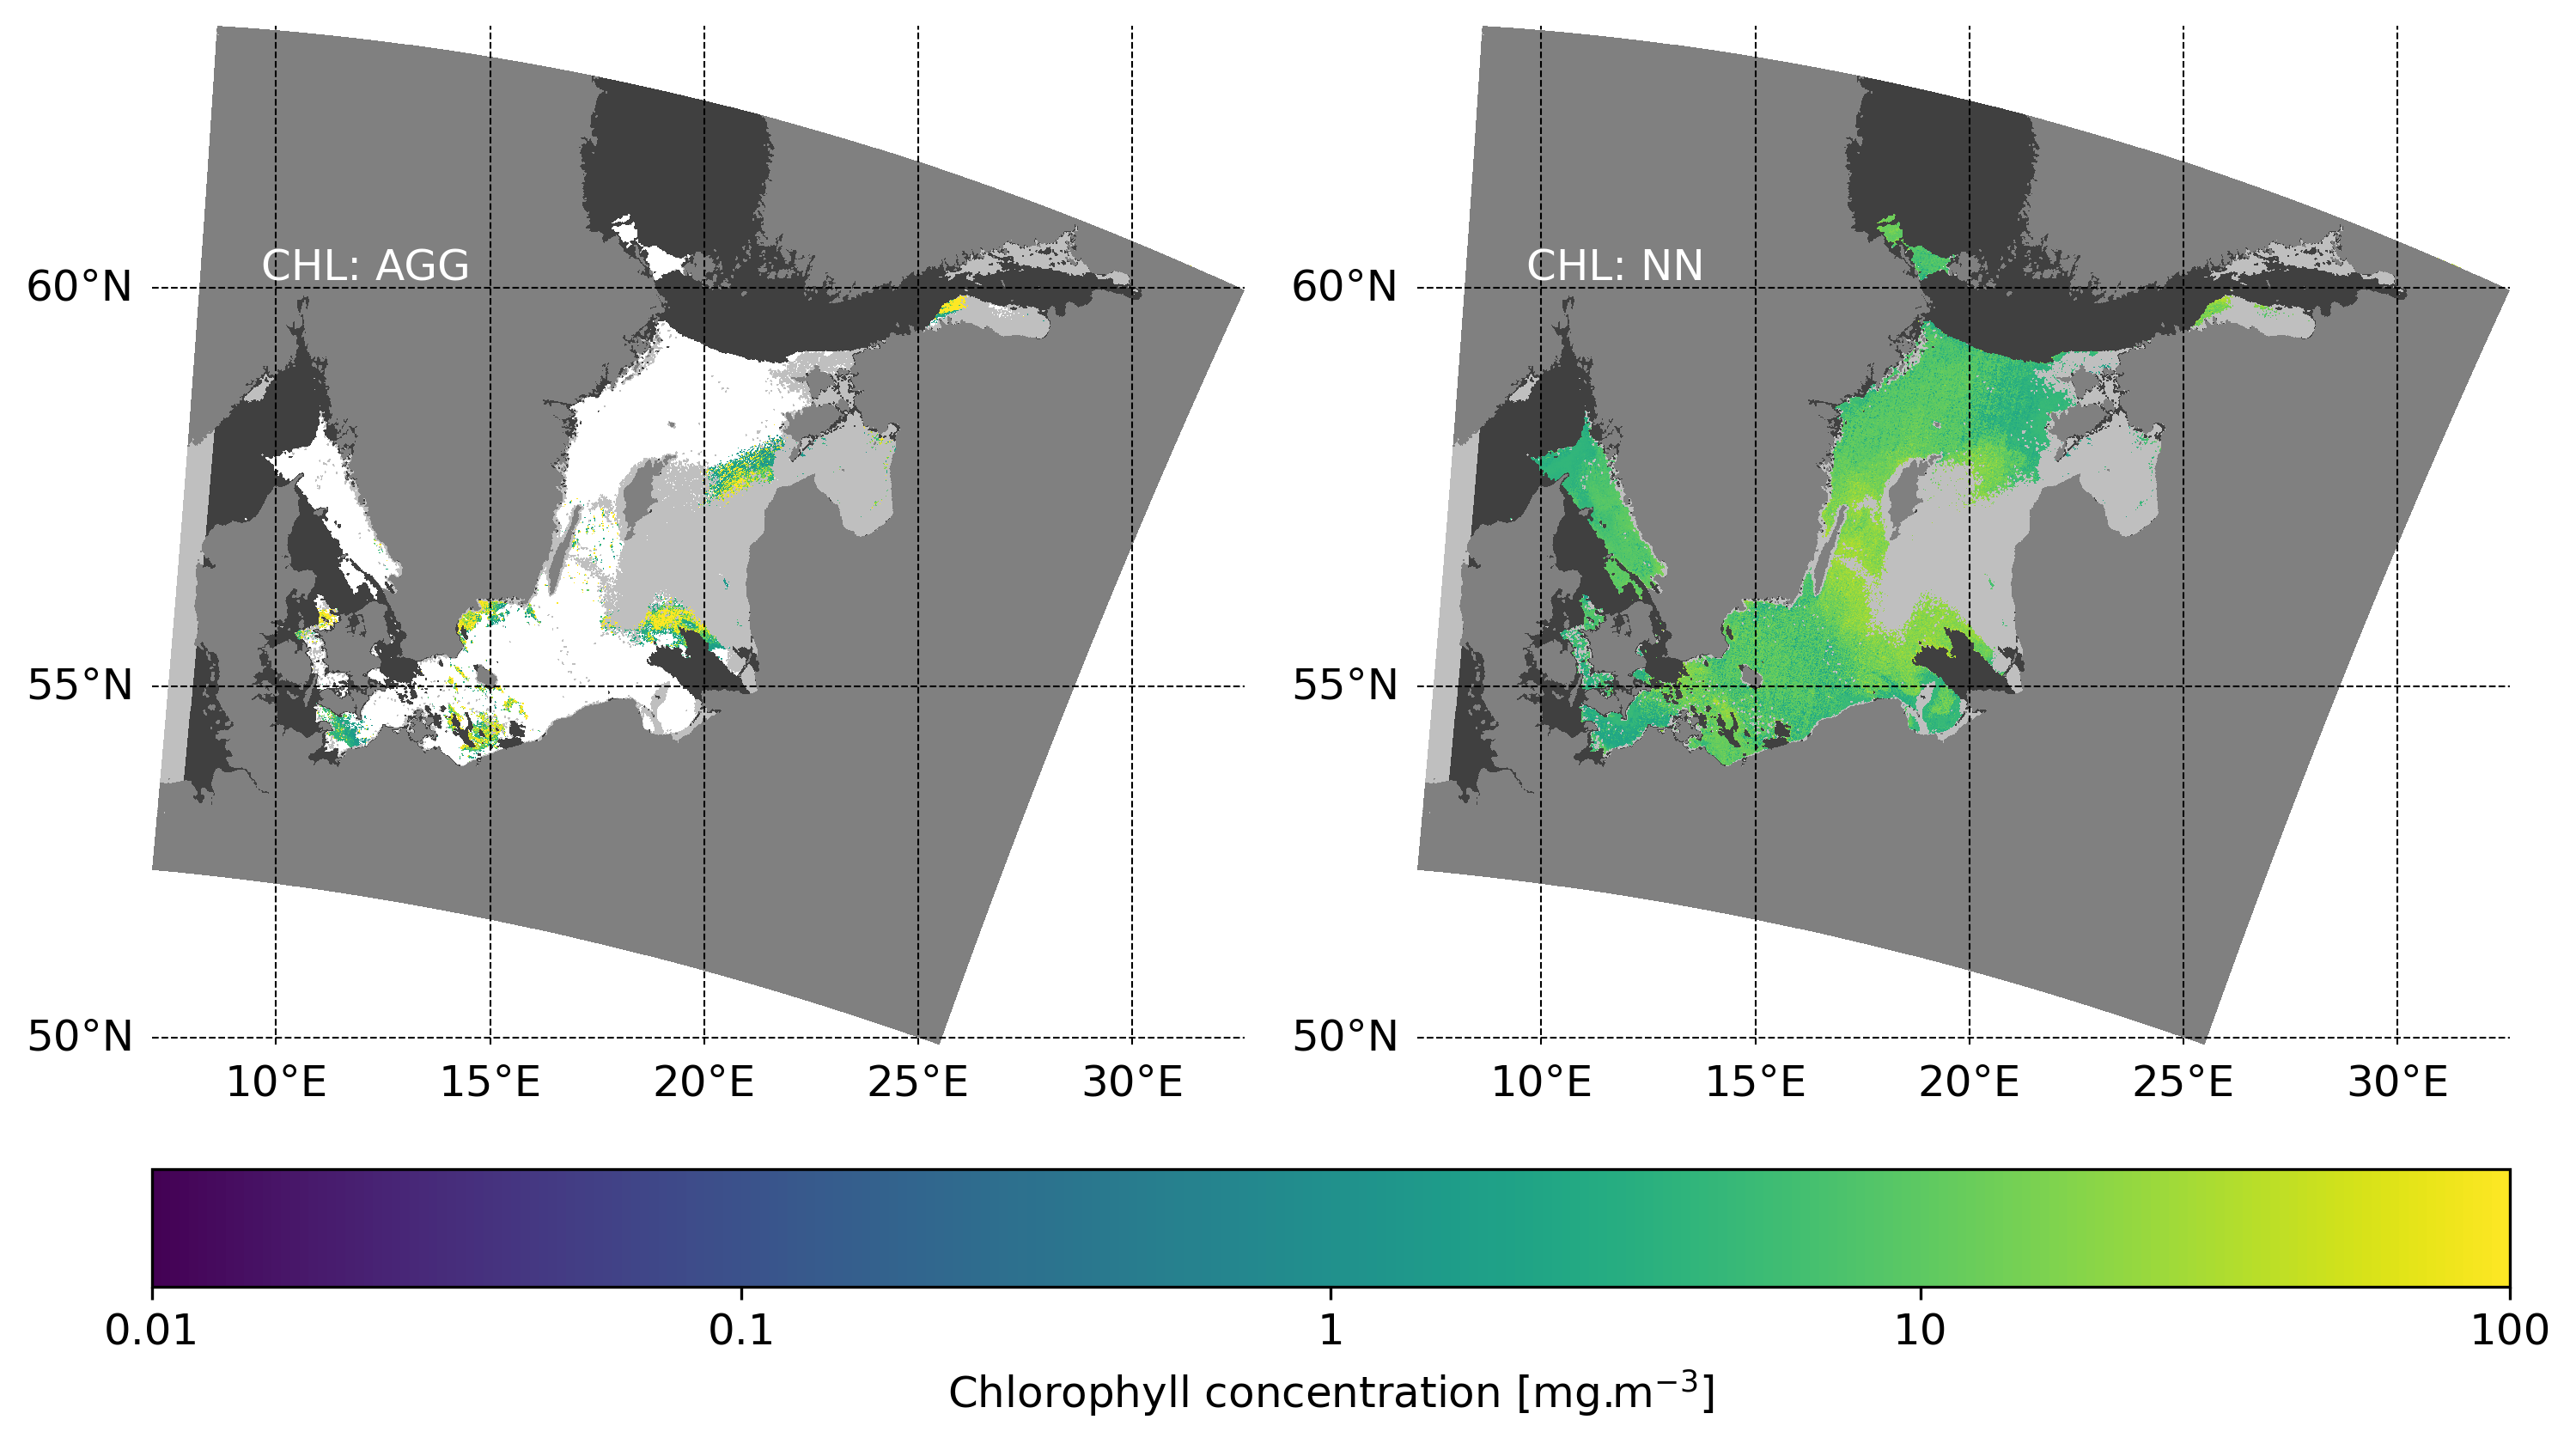

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=300, subplot_kw={"projection": ccrs.Mercator()})

for m, var, cmap, all_mask in zip(axs.reshape(-1),
                         ['CHL_AGG', 'CHL_NN'],
                         ['viridis','viridis'],[NN_mask, NN_mask]):
    
    p1 = m.pcolormesh(lon, lat, band_vars[var][::grid_reduce, ::grid_reduce], transform=ccrs.PlateCarree(), 
                       cmap=cmap, vmin=-2, vmax=2, zorder=1)

    m.contourf(lon, lat, all_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.75', zorder=2)
    m.contourf(lon, lat, cloud_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.25', zorder=3)
    m.contourf(lon, lat, land_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.5', zorder=4)

    m.annotate(f"{var.replace('_',': ')}", xy=(0.1, 0.75), xycoords='axes fraction',
            transform=ccrs.PlateCarree(), zorder=30, color='w')

    # Embellish with gridlines
    g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--', linewidth=0.5)
    g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
    g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
    g1.top_labels = False
    g1.right_labels = False
    g1.xlabel_style = {'color': 'black'}
    g1.ylabel_style = {'color': 'black'}
    m.set(facecolor = "1.0")
    m.axis('off')

plt.tight_layout()

cbar = fig.colorbar(p1, ax=axs[:], location='bottom', pad=0.05)
ticks = [-2,-1,0,1,2]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**tick for tick in ticks])
cbar.set_label('Chlorophyll concentration [mg.m$^{-3}$]')
plt.savefig('1_6_OLCI_CHL.png', bbox_inches='tight')

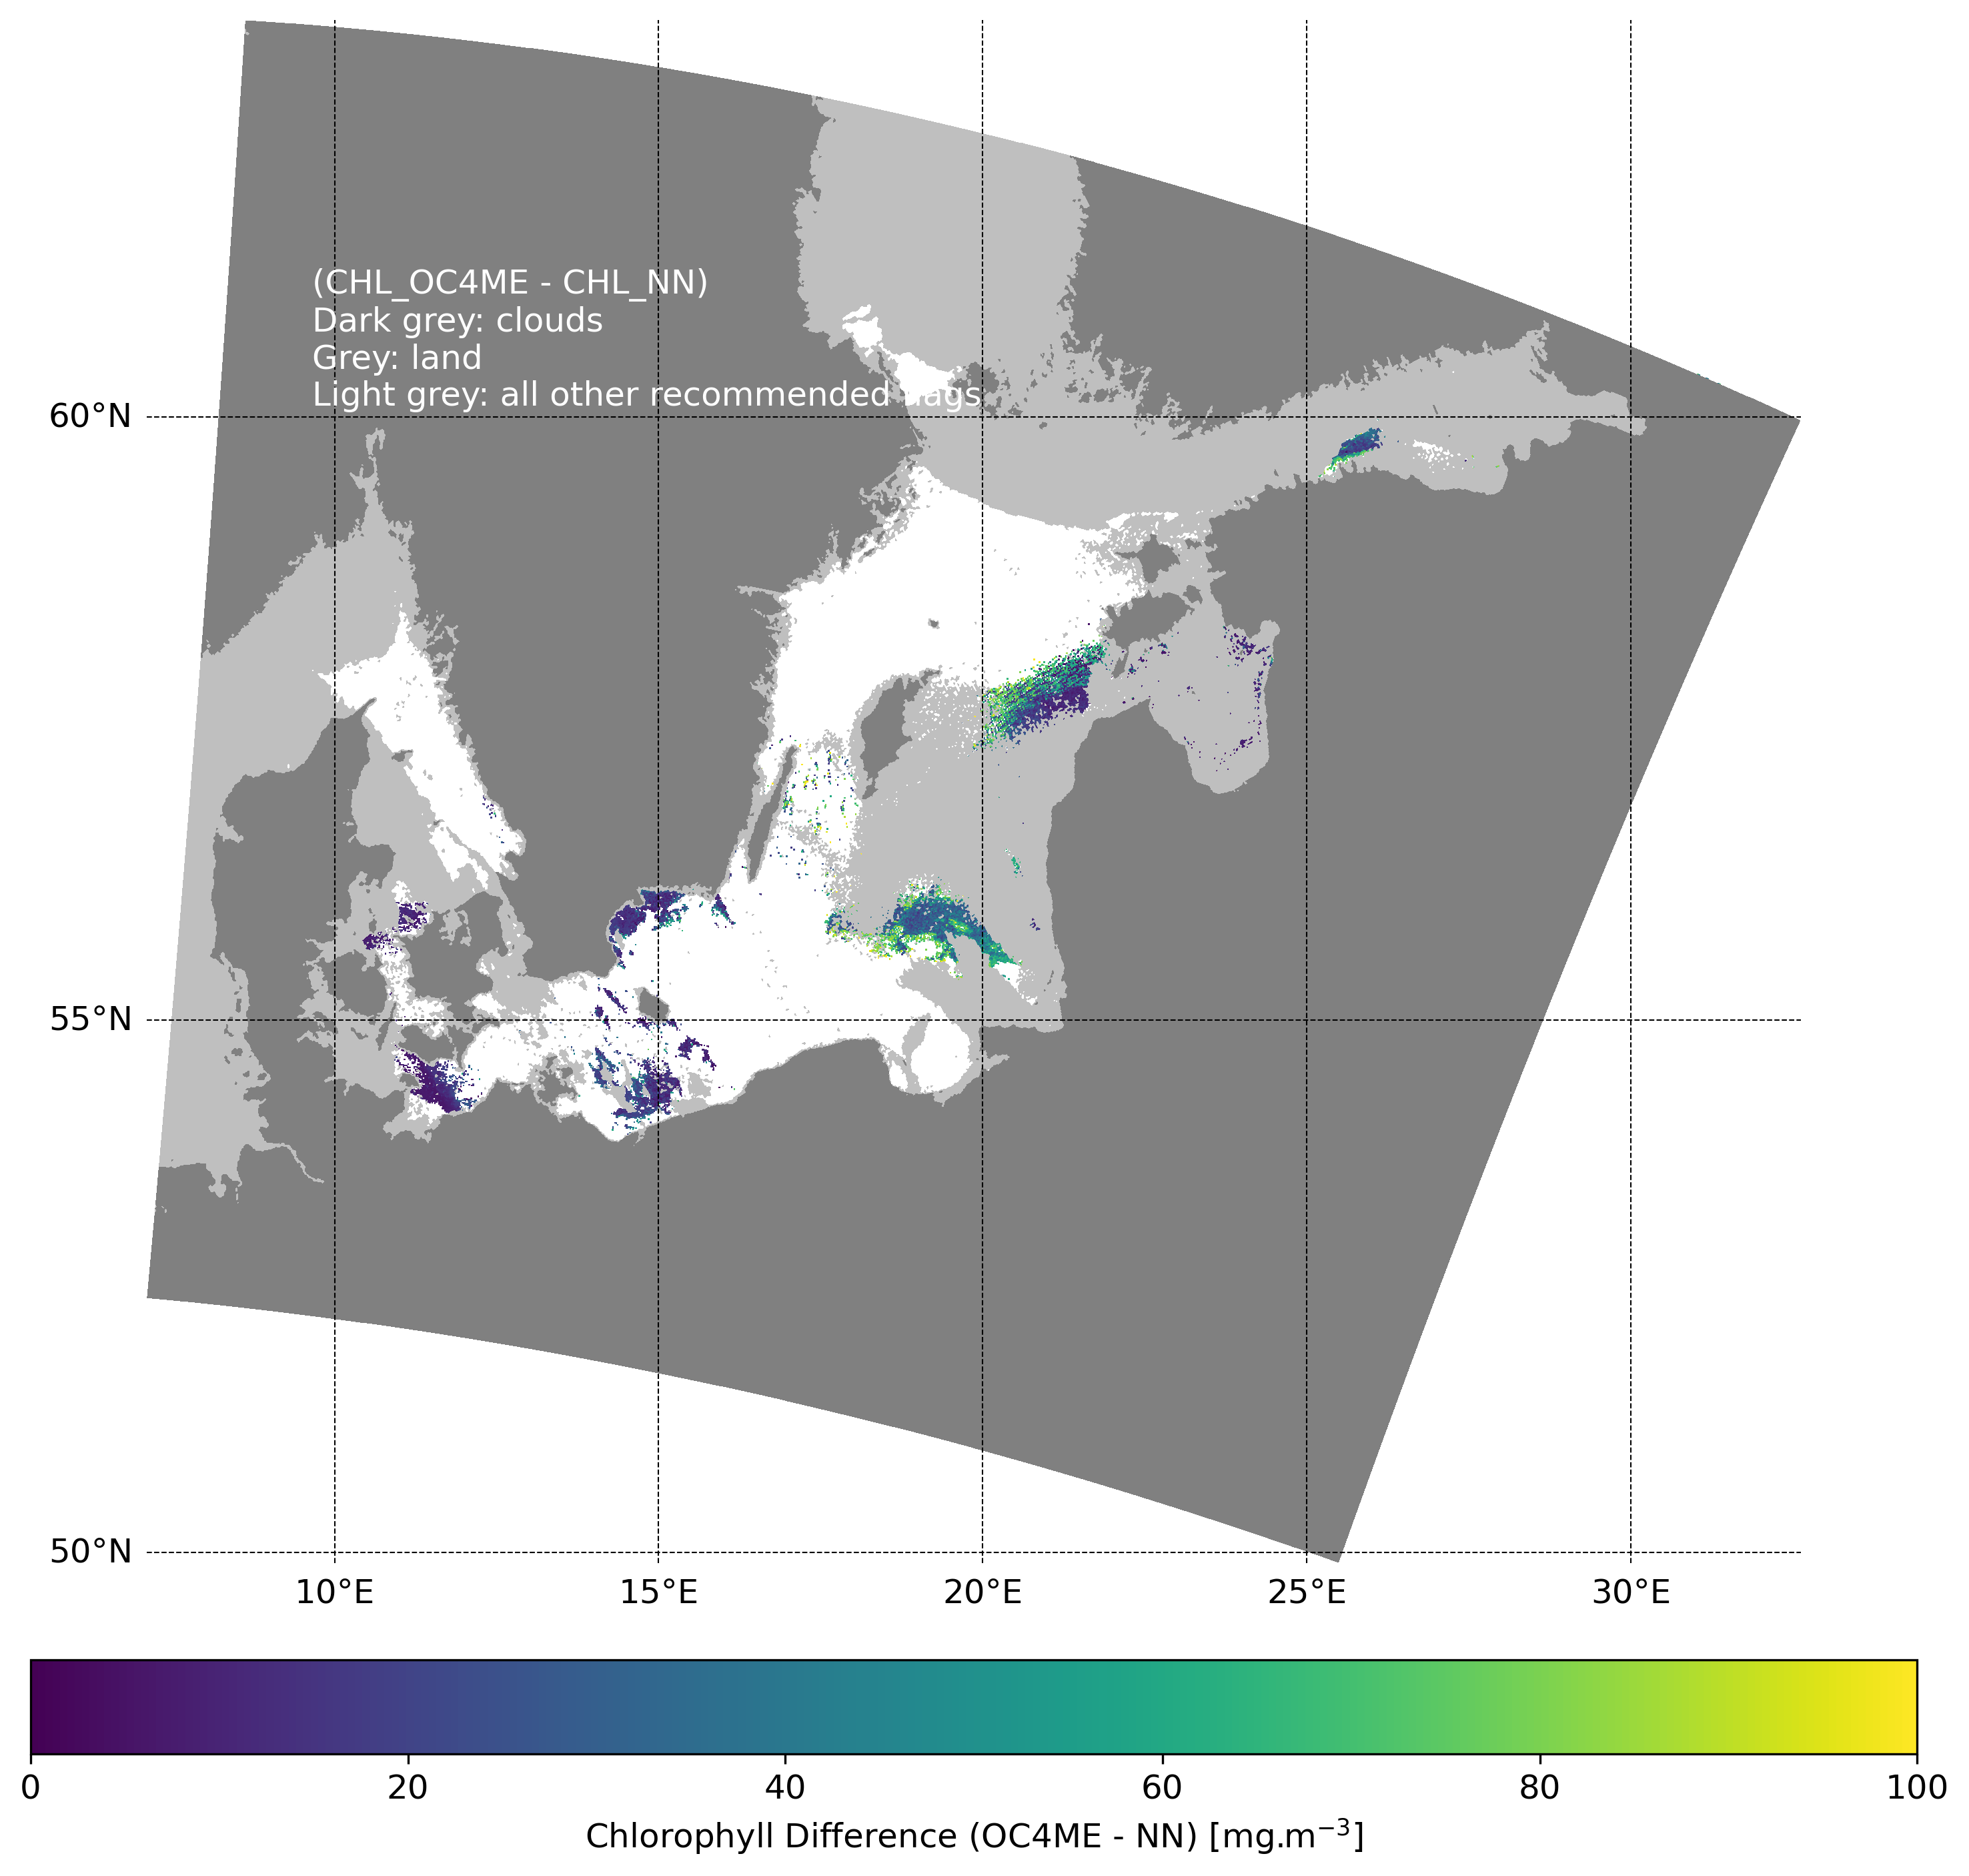

In [19]:
fig = plt.figure(figsize=(10, 10), dpi=300)
m = plt.subplot(projection=ccrs.Mercator())

p1 = m.pcolormesh(lon, lat, band_vars['CHL_AGG'][::grid_reduce, ::grid_reduce], transform=ccrs.PlateCarree(), 
                   cmap=plt.cm.viridis, vmin=0, vmax=100, zorder=1)

m.contourf(lon, lat, NN_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.75', zorder=2)
m.contourf(lon, lat, NN_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.75', zorder=2)
# m.contourf(lon, lat, cloud_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.25', zorder=3)
m.contourf(lon, lat, land_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.5', zorder=4)

m.annotate("(CHL_OC4ME - CHL_NN)\nDark grey: clouds\nGrey: land\nLight grey: all other recommended flags",
           xy=(0.1, 0.75), xycoords='axes fraction', transform=ccrs.PlateCarree(), zorder=30, color='w')

# Embellish with gridlines
g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--',linewidth=0.5)
g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
g1.top_labels = False
g1.right_labels = False
g1.xlabel_style = {'color': 'black'}
g1.ylabel_style = {'color': 'black'}
m.set(facecolor = "1.0")
m.axis('off')

cbar = fig.colorbar(p1, location='bottom', pad=0.05)
cbar.set_label('Chlorophyll Difference (OC4ME - NN) [mg.m$^{-3}$]')
plt.tight_layout()
plt.savefig('1_6_OLCI_CHL_diff.png', bbox_inches='tight')